## Daisyworld simulation in bivariate plots

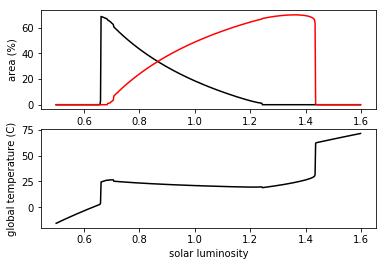

In [6]:
import numpy as np
import matplotlib.pyplot as plt

REVERSE = False
# Temperatures
KELVIN_OFFSET = 273.15
Td_min = 5 + KELVIN_OFFSET
Td_max = 40 + KELVIN_OFFSET
Td_ideal_black = 22.5 + KELVIN_OFFSET
Td_ideal_white = 22.5 + KELVIN_OFFSET

# Albedo
alb_white = 0.75
area_white = 0.01
alb_black = 0.25
area_black = 0.01
alb_barren = 0.5
insul = 20
drate = 0.3

# Convergence criteria
maxconv = 1000
tol = 0.000001

# Flux terms
So = 1000
sigma = 5.67032e-8

# Flux limits and step
Sflux_min = 0.5
Sflux_max = 1.6
Sflux_step = 0.002

# If run from command line, do the whole thing
if __name__ == '__main__':
    """Run the daisyworld model"""
    # Initialize arrays
    fluxes = np.arange(Sflux_min, Sflux_max, Sflux_step)
    if REVERSE:
        fluxes = fluxes[::-1]
    area_black_vec = np.zeros_like(fluxes)
    area_white_vec = np.zeros_like(fluxes)
    area_barren_vec = np.zeros_like(fluxes)
    Tp_vec = np.zeros_like(fluxes)

    # Loop over fluxes
    for j, flux in enumerate(fluxes):
        # Minimum daisy coverage
        if area_black < 0.01:
            area_black = 0.01
        if area_white < 0.01:
            area_white = 0.01
        area_barren = 1 - (area_black + area_white)

        # Reset iteration metrics
        it = 0
        dA_black = 2*tol
        dA_white = 2*tol
        darea_black_old = 0
        darea_white_old = 0

        while it <= maxconv and dA_black > tol and dA_white > tol:
            # Planetary albedo
            alb_p = (area_black * alb_black
                     + area_white * alb_white
                     + area_barren * alb_barren)
            # Planetary temperature
            Tp = np.power(flux*So*(1-alb_p)/sigma, 0.25)
            # Local temperatures
            Td_black = insul*(alb_p-alb_black) + Tp
            Td_white = insul*(alb_p-alb_white) + Tp

            # Determine birth rates
            if (Td_black >= Td_min
                    and Td_black <= Td_max
                    and area_black >= 0.01):
                birth_black = 1 - 0.003265*(Td_ideal_black-Td_black)**2
            else:
                birth_black = 0.0

            if (Td_white >= Td_min
                    and Td_white <= Td_max
                    and area_white >= 0.01):
                birth_white = 1 - 0.003265*(Td_ideal_white-Td_white)**2
            else:
                birth_white = 0.0

            # Change in areal extents
            darea_black = area_black*(birth_black*area_barren-drate)
            darea_white = area_white*(birth_white*area_barren-drate)

            # Change from previous iteration
            dA_black = abs(darea_black-darea_black_old)
            dA_white = abs(darea_white-darea_white_old)

            # Update areas, states, and iteration count
            darea_black_old = darea_black
            darea_white_old = darea_white
            area_black = area_black+darea_black
            area_white = area_white+darea_white
            area_barren = 1-(area_black+area_white)
            it += 1

        # Save states
        area_black_vec[j] = area_black
        area_white_vec[j] = area_white
        area_barren_vec[j] = area_barren
        Tp_vec[j] = Tp

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(fluxes, 100*area_black_vec, color='black', label='black')
    ax[0].plot(fluxes, 100*area_white_vec, color='red', label='white')
    ax[0].set_xlabel('solar luminosity')
    ax[0].set_ylabel('area (%)')

    ax[1].plot(fluxes, Tp_vec-KELVIN_OFFSET, color='black')
    ax[1].set_xlabel('solar luminosity')
    ax[1].set_ylabel('global temperature (C)')
    plt.show()

### Implementation of the Daisyworld model described in:  

Watson, A.J.; Lovelock, J.E (1983). "Biological homeostasis of the global environment: the parable of Daisyworld". Tellus.35B: 286–9. doi:10.1111/j.1600-0889.1983.tb00031.x.  

Copyright (c) 2017 Andrew Bennett, Peter Greve, Eric Jaeger  
All rights reserved.  